# モンティ・ホール問題を機械学習（強化学習）で解く

機械学習は、[演繹的（論理学的）アプローチから、帰納的（統計学的）アプローチへのパラダイム転換なんだ](https://qiita.com/tanuk1647/items/cdf2f18335008a428bf8#%E7%A7%81%E3%81%AE%E7%90%86%E8%A7%A3)と私は考えています。

さて、~~論理的に考えて納得のいかない~~論理的解答と直感的解答の食い違う問題の代表選手が、**モンティ・ホール問題**といえるでしょう。（お前の論理が間違っているんだというツッコミは無しで。）今回は、この問題を機械学習（強化学習）の手法で統計的に解いてみたいと思います。

さらに、モンティ・ホール問題の本質に迫ってみたいと思います。

## モンティ・ホール問題

プレーヤーの前に閉まった3つのドアがあって、1つのドアの後ろには景品の新車が、2つのドアの後ろには、はずれを意味するヤギがいる。プレーヤーは新車のドアを当てると新車がもらえる。プレーヤーが1つのドアを選択した後、司会のモンティが残りのドアのうちヤギがいるドアを開けてヤギを見せる。

ここでプレーヤーは、最初に選んだドアを、残っている開けられていないドアに変更してもよいと言われる。プレーヤーはドアを変更すべきだろうか？

[Wikipedia『モンティ・ホール問題』](https://ja.wikipedia.org/wiki/%E3%83%A2%E3%83%B3%E3%83%86%E3%82%A3%E3%83%BB%E3%83%9B%E3%83%BC%E3%83%AB%E5%95%8F%E9%A1%8C)

## 問題の正解

[西尾維新『終物語・上』](http://iss.ndl.go.jp/books/R100000002-I024912913-00)にて、阿良々木君が解答してくれていますが、ドアを変更するのが正解です。

> 忍野扇「選び直そうが直すまいが、確率的には一緒じゃないです？」
> 
> 阿良々木暦「回答を選び直すが正解なんだ」

扇ちゃん同様、五分五分なんじゃないかというのが、多くの人の直感でしょう。

実際、[Wikipediaの上記記事](https://ja.wikipedia.org/wiki/%E3%83%A2%E3%83%B3%E3%83%86%E3%82%A3%E3%83%BB%E3%83%9B%E3%83%BC%E3%83%AB%E5%95%8F%E9%A1%8C)によると、ニュース雑誌にてこの問題が取り上げられた際、IQ228の持ち主でもある[マリリン・ボス・サバント](https://ja.wikipedia.org/wiki/%E3%83%9E%E3%83%AA%E3%83%AA%E3%83%B3%E3%83%BB%E3%83%9C%E3%82%B9%E3%83%BB%E3%82%B5%E3%83%90%E3%83%B3%E3%83%88)が掲載した回答——正解は「ドアを変更する」である。なぜなら、ドアを変更した場合には景品を当てる確率が2倍になるからだ——に対し、読者から「彼女の解答は間違っている」という約1万通の投書が殺到したそうです。

投書には、1000人近い博士号保持者からのものも含まれており、その大部分は「ドアを変えても確率は五分五分（2分の1）であり、3分の2にはならない」とするものであったそうです。

博士号保持者といえば、社会の中でも、論理的思考が得意な人たちといえるでしょう。にも関わらず、この問題の論理的帰結——正解——は、「ドアの選択を選び直す」なのです。

（2018/08/19追記）
このことは——コメントを頂きましたが——いくつかの方法で論理的に示すことができます。例えば、場合分けして直接計算する方法や、[ベイズの定理を用いる方法](https://qiita.com/ysk24ok/items/c87a73fd2ee16091ec91)で示すことができます。前者はわかりやすいですし、後者は形式的で、数学的に美しいです。

本記事ではPythonを使って、統計的に解きたいと思います。

## モンティ・パイソンな方々

Qiitaでモンティ・ホール問題をPythonで解かれている方々です。何事も先達を見つけるのは嬉しいものです。

- [モンティ・ホール問題を解く](https://qiita.com/ynakayama/items/1e1693503e27ce33e0a0)
- [「モンティ・ホール問題」の簡単なシミュレーションプログラムを書いてみる](https://qiita.com/neko_the_shadow/items/0720fa0fe41260dbbf8c)
- [モンティ・ホール問題をコード書いて勝率計算したらすごく納得した話](https://qiita.com/shngt/items/b00f9f7460ca3807598f)
- [君は、モンティ・ホール問題を理解しているか?](https://qiita.com/gyu-don/items/0aaad14ebb2f0771839d)
- [モンティ・ホール問題をプログラミングで解く](https://qiita.com/mastar_3104/items/a227f3665b95ffe73a36)

それぞれ、問題内容・経緯を詳しく解説されていたり、グラフで図示してプレゼンされていたり、短くリファクタリングされていたり、突風が吹く／正解をシャッフルするなどのルール変更によりこの問題の本質に迫られていたりと、特色ある記事だと思います。

本記事の特徴は、機械学習の一種である強化学習（**Q学習**）の手法でこの問題を解く、というところにあります。

## 強化学習（Q学習）とは

以下の記事や書籍が詳しく、わかりやすく、勉強になります。

- [ゼロからDeepまで学ぶ強化学習](https://qiita.com/icoxfog417/items/242439ecd1a477ece312)
- [強化学習入門 ～これから強化学習を学びたい人のための基礎知識～ ](http://blog.brainpad.co.jp/entry/2017/02/24/121500)
- [小高知宏（2018）『機械学習(マシンラーニング)と深層学習(ディープラーニング)』オーム社](http://iss.ndl.go.jp/books/R100000002-I028959772-00)の2.2節

Q学習にもバリエーションがあるようですが、最もシンプルなものを考えると、以下特徴を挙げることができるでしょう。

- **Q値**とは、ある行動から得られる報酬の見込みに比例した数値であり、行動指針となるものである。
- ε（イプシロン）の確率でランダム行動を、1-εの確率でQ値に応じた行動を実施する（ε-greedy法）。
- （最終的な報酬がわかっていなくても）各ステップの行動中に、少しずつQ値を更新していく。具体的には、報酬の期待値（＝次ステップのQ値の最大値）と現ステップのQ値の差分をもとに、現ステップのQ値を更新する（TD学習）。

以上の点については、具体的なプログラムを見ながら説明したいと思います。

## プログラム説明

### ライブラリのインポート

今回は、必要最小限でいきたいと思います。

```python
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
```

### メイン関数

ハイパーパラメータの設定、登場人物のインスタンス化、訓練、そして実戦という流れです。まあ、そう書きますよね。

```python
def main():
    # ハイパーパラメータ
    epochs = 100
    batch_size = 100
    α = 0.1
    γ = 0.9
    ε = 0.3
    
    # 登場人物
    m = Monty()
    p = Player()
    t = Trainer(epochs=epochs
                , batch_size=batch_size
                , α=α, γ=γ, ε=ε)

    # 訓練、そして実戦
    p = t.train(m, p)
    apply(m, p, 1000)
```

### 実戦

ゲームのループを1000回まわして、勝率を求めます。

ゲームの流れは（ドアの応酬に見えてなんだか奇妙ですが）問題の設定に忠実に従ったものです。あえて、リファクタリングはしません。

```python
def apply(m, p, n=1000):
    w = 0
    p.istraining = False
    for i in range(n):
        doors1 = m.reset()
        doors2 = p.choice(doors1)
        doors3 = m.open(doors2)
        doors4 = p.rechoice(doors3)
        reward = m.judge(doors4)
        if reward > 0.:
            w += 1
    win_rate = w/n
    print('実戦勝率：' + str(win_rate))
    return win_rate
```

### モンティ

続いては、モンティです。コーディングの巧拙はさておき、司会者としての役目を忠実にこなしているだけなので、特に説明不要かと思います。

```python
class Monty:
    def reset(self):
        # ゲームを初期化
        m_doors = np.zeros(3)
        self.__car = np.zeros(3)
        self.__car[nrand.randint(3)] = 1.
        return m_doors
    
    def open(self, p_doors):
        m_doors = p_doors.copy()
        
        # ドアを一つ開ける
        t = self.__car + m_doors
        choices = np.where(t == 0.)[0]
        choice = nrand.randint(choices.size)
        m_doors[choices[choice]] = 2.
        
        return m_doors
    
    def judge(self, p_doors):
        # 正解判定
        t = np.where(p_doors == 1.)[0][0]
        u = np.where(self.__car == 1.)[0][0]
        judgement = 1000. if t == u else 0.
        return judgement
```

### プレーヤー

少しややこしくなってくるのが、プレーヤーです。メソッドごとに説明したいと思います。

まずは、リセットメソッド。必要に応じ内部状態をリセットできるようにし、コンストラクタからも呼び出しています。メソッド内部ではインスタンス変数の初期化をおこなっていますが、特に重要なのはqとε（イプシロン）です。

```python
    def reset(self):
        self.q1 = np.zeros(3)
        self.q2 = np.zeros(6)
        
        # 乱数で初期化する
        for i in range(self.q1.size):
            self.q1[i] = nrand.random()*1000
        
        for i in range(self.q2.size):
            self.q2[i] = nrand.random()*1000
        
        # 3*2の多次元配列に整形
        self.q2 = self.q2.reshape(3, 2)
        
        self.istraining = False
        self.ε = 0.
```

このゲームは、プレーヤーの取りうる行動のみを考えると、第一ステップで三つに分岐（ドアの選択）、第二ステップで二つに分岐（選択を変更するかしないか選択）します。つまり、１×３×２の木として表現できるわけです。

![木](figures/monty-hall-problem-with-rl-0000.jpg)

各ノード（＝行動）の価値（＝得られる報酬の見込み）をQ値という指標で表します。

第一ステップのQ値は要素が三つの配列です。0：左のドアを選択する、1：中央のドアを選択する、2：右のドアを選択する、に対応します。

第二ステップのQ値は要素が二つの配列です。0：選択を変更しない、1：選択を変更する、に対応します。第一ステップの数により三倍がけされ、３×２の多次元配列としてもちます。

適切なQ値はわからないので、乱数で初期化します。

次に、ε（イプシロン）は、ランダム行動を制御します。Q値に応じて行動するのが基本ですが、一定程度ランダムに行動をおこなわないと、経験の幅が広がりません。そうすると、経験を通じた学習も偏って終わってしまいます。

以下は、ドアの選択メソッドです。ε、および、Q値に応じて、行動を制御しているのが、おわかりいただけるかと思います。

```python
    def choice(self, m_doors):
        p_doors = m_doors.copy()
        
        if self.istraining:
            # 所定の確率で
            if nrand.random() < self.ε:
                # ランダムに行動する
                if nrand.randint(2):
                    self.choiced = nrand.randint(3)
                    p_doors[self.choiced] = 1.
                else:
                    self.choiced = self.q1.argmax()
                    p_doors[self.choiced] = 1.
            else:
                # Q値を参照して行動する
                self.choiced = self.q1.argmax()
                p_doors[self.choiced] = 1.
        else:
            # Q値を参照して行動する
            self.choiced = self.q1.argmax()
            p_doors[self.choiced] = 1.
        
        return p_doors
```

なお、ドアを選択しなおすメソッド（rechoice）も別途定義していますが、中身は似たようなものなので、説明を割愛します。

### トレーナー

最後は、トレーナーです。

コンストラクタはハイパーパラメータを受けているだけなので、説明を割愛します。

重要なのは、訓練メソッド。グラフ表示に関わる部分を除いたコードを、以下に掲載します。

エポックとバッチの二重ループにしているのは、グラフ表示の都合上と、エポック単位でハイパーパラメータを更新できるようにするためです。

```python
    def train(self, m, p):
        p.istraining = True
        p.ε = self.ε
        
        for i in range(1, self.epochs+1):
            for j in range(self.batch_size):
                doors1 = m.reset()
                
                doors2 = p.choice(doors1)
                q1 = p.q1[p.choiced]
                q1 += self.α * (self.γ * p.q2[p.choiced].max() - q1)
                p.q1[p.choiced] = q1
                
                doors3 = m.open(doors2)
                
                doors4 = p.rechoice(doors3)
                q2 = p.q2[p.choiced][p.rechoiced]
                q2 += self.α * (m.judge(doors4) - q2)
                p.q2[p.choiced][p.rechoiced] = q2
            
            self.α *= 0.95
        
        return p
```

ポイントはQ値の更新タイミングと、更新内容です。

更新タイミングは、最終的に報酬が得られてからでなく、行動をとった直後にQ値を更新するのが特徴です。ニューラルネットワークで例えるなら、逆伝播でなく順伝播の最中に、特徴量を更新していくようなものです。このやり方なら、状態遷移が複雑になったときでも、シンプルに実装できるでしょう。

更新内容については、第一ステップ（q1）、第二ステップ（q2）のいずれも、期待値 or 実際の報酬と、見込み（＝Q値）の差分となっています。

第二ステップについては、実際の報酬とQ値の差分に学習率αをかけたもので、Q値を更新しています。この更新を繰り返すことで、報酬を得やすい行動のQ値が上がり、得にくい行動のQ値が下がっていきます。報酬を得やすい行動と得にくい行動のQ値の比が、一定の値に収束していくのです。

第一ステップについては、第二ステップのQ値のMAXを割引率γで割り引いたもの（＝期待値）とQ値との差分をとって、学習率αを乗じて更新しています。第二ステップのQ値は次第に最適化されていくので、第一ステップのQ値も連れだって、最適化されていきます。

## ソースコード

以下に、ソースコードの全体像を示します。

In [1]:
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt

class Player:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.q1 = np.zeros(3)
        self.q2 = np.zeros(6)
        
        # 乱数で初期化する
        for i in range(self.q1.size):
            self.q1[i] = nrand.random()*1000
        
        for i in range(self.q2.size):
            self.q2[i] = nrand.random()*1000
        
        # 3*2の多次元配列に整形
        self.q2 = self.q2.reshape(3, 2)
        
        self.istraining = False
        self.ε = 0.
    
    def choice(self, m_doors):
        p_doors = m_doors.copy()
        
        if self.istraining:
            # 所定の確率で
            if nrand.random() < self.ε:
                # ランダムに行動する
                if nrand.randint(2):
                    self.choiced = nrand.randint(3)
                    p_doors[self.choiced] = 1.
                else:
                    self.choiced = self.q1.argmax()
                    p_doors[self.choiced] = 1.
            else:
                # Q値を参照して行動する
                self.choiced = self.q1.argmax()
                p_doors[self.choiced] = 1.
        else:
            # Q値を参照して行動する
            self.choiced = self.q1.argmax()
            p_doors[self.choiced] = 1.
        
        return p_doors
    
    def rechoice(self, m_doors):
        p_doors = m_doors.copy()
        
        if self.istraining:
            # 所定の確率で
            if nrand.random() < self.ε:
                # ランダムに行動する
                if nrand.randint(2):
                    self.rechoiced = 1
                    p_doors = self.__rechoice(p_doors)
                else:
                    self.rechoiced = 0
            else:
                # Q値を参照して行動する
                if self.q2[self.choiced].argmax():
                    self.rechoiced = 1
                    p_doors = self.__rechoice(p_doors)
                else:
                    self.rechoiced = 0
        else:
            # Q値を参照して行動する
            if self.q2[self.choiced].argmax():
                p_doors = self.__rechoice(p_doors)
                self.rechoiced = 1
            else:
                self.rechoiced = 0
        
        return p_doors
    
    def __rechoice(self, p_doors):
        # ドアの選択を変更するだけのメソッド
        doors = p_doors.copy()
        choices = np.where(doors == 0.)[0]
        doors[choices] = 1.
        doors[self.choiced] = 0.
        return doors

class Monty:
    def reset(self):
        # ゲームを初期化
        m_doors = np.zeros(3)
        self.__car = np.zeros(3)
        self.__car[nrand.randint(3)] = 1.
        return m_doors
    
    def open(self, p_doors):
        m_doors = p_doors.copy()
        
        # ドアを一つ開ける
        t = self.__car + m_doors
        choices = np.where(t == 0.)[0]
        choice = nrand.randint(choices.size)
        m_doors[choices[choice]] = 2.
        
        return m_doors
    
    def judge(self, p_doors):
        # 正解判定
        t = np.where(p_doors == 1.)[0][0]
        u = np.where(self.__car == 1.)[0][0]
        judgement = 1000. if t == u else 0.
        return judgement

class Trainer:
    def __init__(self, epochs, batch_size, α, γ, ε):
        self.epochs = epochs
        self.batch_size = batch_size
        self.α, self.γ, self.ε = α, γ, ε
    
    def train(self, m, p):
        x = [0]
        a, b, c = [p.q1[0]], [p.q1[1]], [p.q1[2]]
        t_d = p.q2[0][0] + p.q2[1][0] + p.q2[2][0]
        t_e = p.q2[0][1] + p.q2[1][1] + p.q2[2][1]
        d = [t_d]
        e = [t_e]
        f = [t_e / t_d]
        p.istraining = True
        p.ε = self.ε
        
        for i in range(1, self.epochs+1):
            for j in range(self.batch_size):
                doors1 = m.reset()
                
                doors2 = p.choice(doors1)
                q1 = p.q1[p.choiced]
                q1 += self.α * (self.γ * p.q2[p.choiced].max() - q1)
                p.q1[p.choiced] = q1
                
                doors3 = m.open(doors2)
                
                doors4 = p.rechoice(doors3)
                q2 = p.q2[p.choiced][p.rechoiced]
                q2 += self.α * (m.judge(doors4) - q2)
                p.q2[p.choiced][p.rechoiced] = q2
            
            self.α *= 0.95
            
            x.append(i)
            a.append(p.q1[0])
            b.append(p.q1[1])
            c.append(p.q1[2])
            t_d = p.q2[0][0] + p.q2[1][0] + p.q2[2][0]
            t_e = p.q2[0][1] + p.q2[1][1] + p.q2[2][1]
            d.append(t_d)
            e.append(t_e)
            f.append(t_e / t_d)
        
        plt.figure()
        plt.plot(x, a, marker='.', alpha=0.2, label='左のドアを選択する')
        plt.plot(x, b, marker='.', alpha=0.2, label='中央のドアを選択する')
        plt.plot(x, c, marker='.', alpha=0.2, label='右のドアを選択する')
        plt.plot(x, d, marker='.', label='選択を変更しない')
        plt.plot(x, e, marker='.', label='選択を変更する')
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('エポック')
        plt.ylabel('Q値')
        plt.show()
        
        plt.figure()
        plt.plot(x, f, marker='.', label='変更する／しないの比')
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('エポック')
        plt.ylabel('Q値の比')
        plt.show()
        
        return p

def apply(m, p, n=1000):
    w = 0
    p.istraining = False
    for i in range(n):
        doors1 = m.reset()
        doors2 = p.choice(doors1)
        doors3 = m.open(doors2)
        doors4 = p.rechoice(doors3)
        reward = m.judge(doors4)
        if reward > 0.:
            w += 1
    win_rate = w/n
    print('実戦勝率：' + str(win_rate))
    return win_rate

def main():
    # ハイパーパラメータ
    epochs = 100
    batch_size = 500
    α = 0.1
    γ = 0.9
    ε = 0.3
    
    # 登場人物
    m = Monty()
    p = Player()
    t = Trainer(epochs=epochs
                , batch_size=batch_size
                , α=α, γ=γ, ε=ε)

    # 訓練、そして実戦
    p = t.train(m, p)
    apply(m, p, 1000)

## 実行結果

以下にプログラムの実行結果を示します。

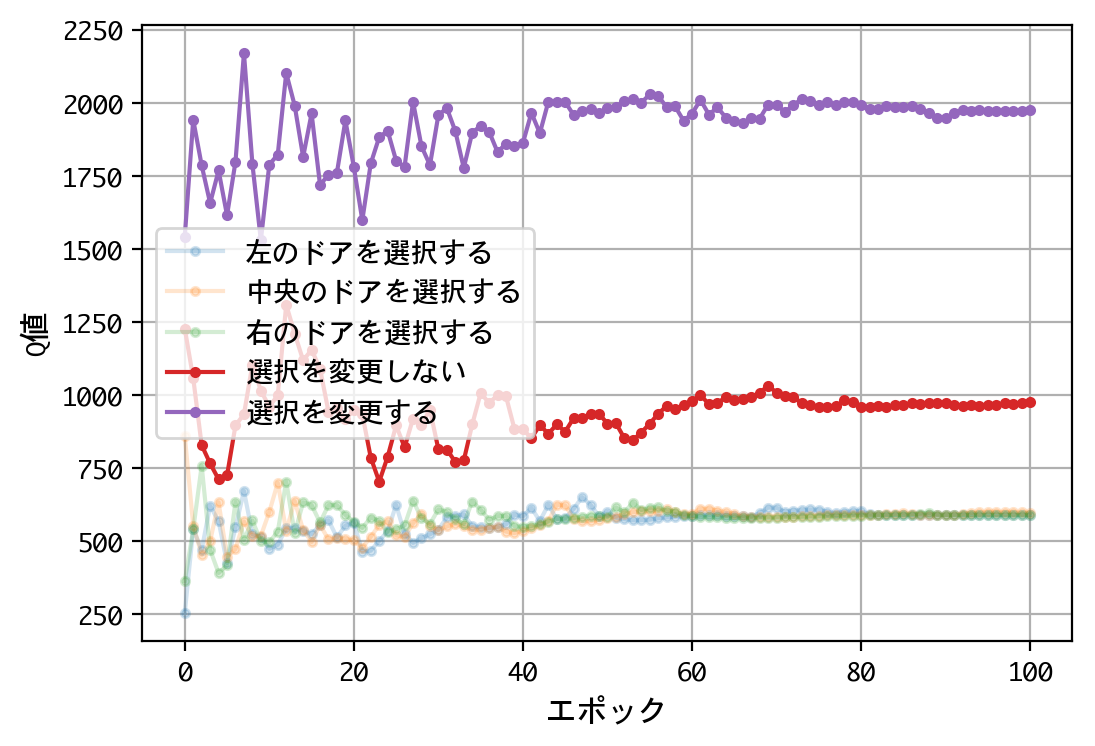

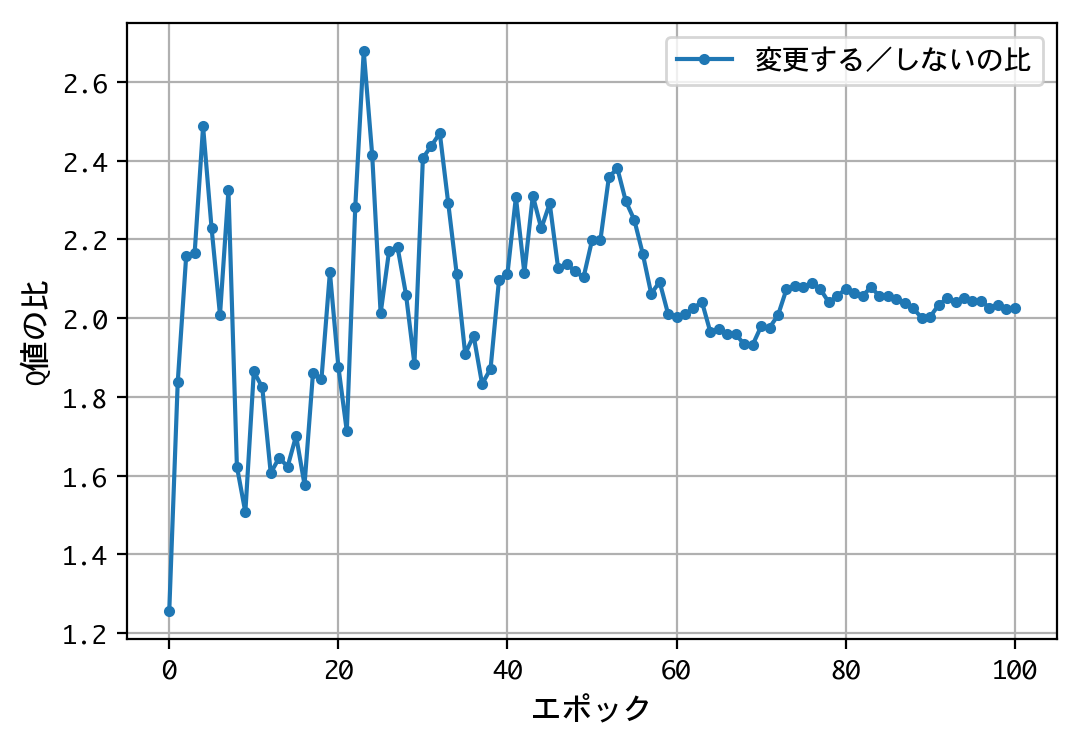

実戦勝率：0.668


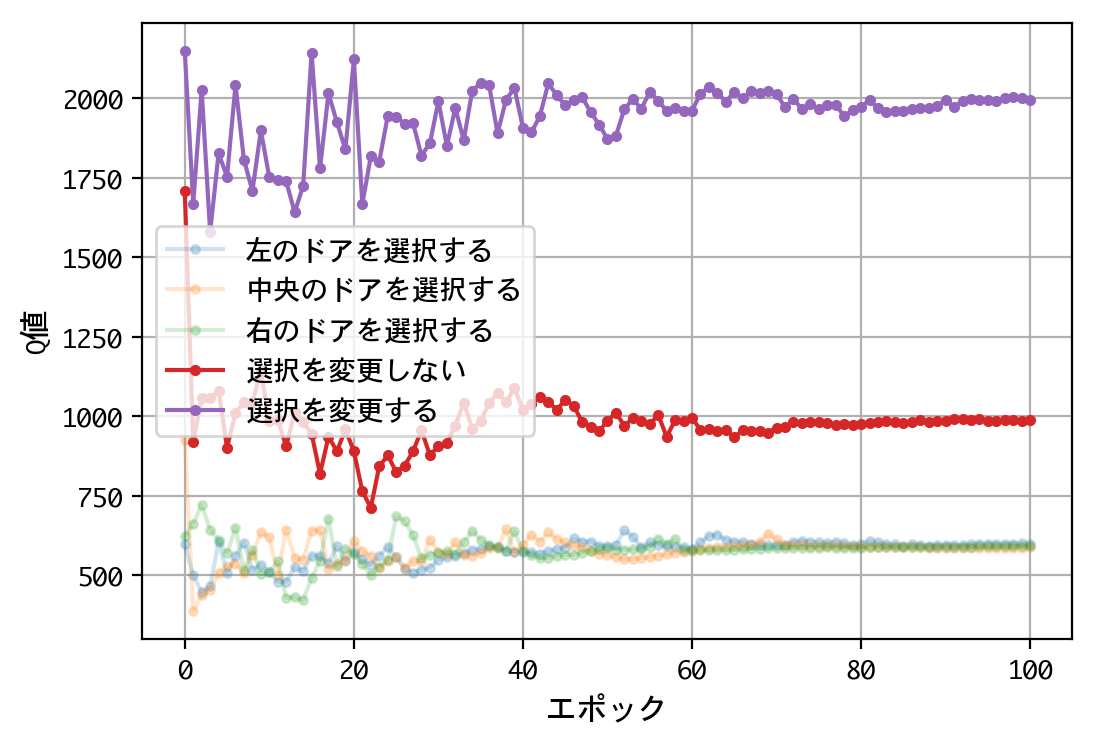

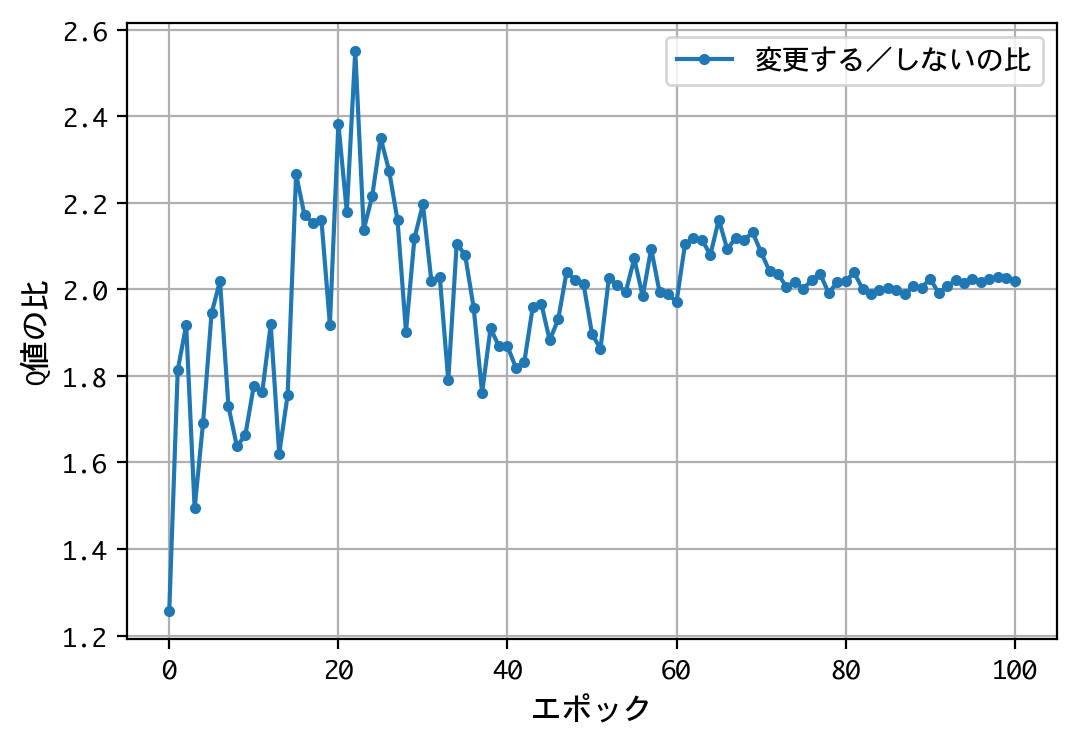

実戦勝率：0.657


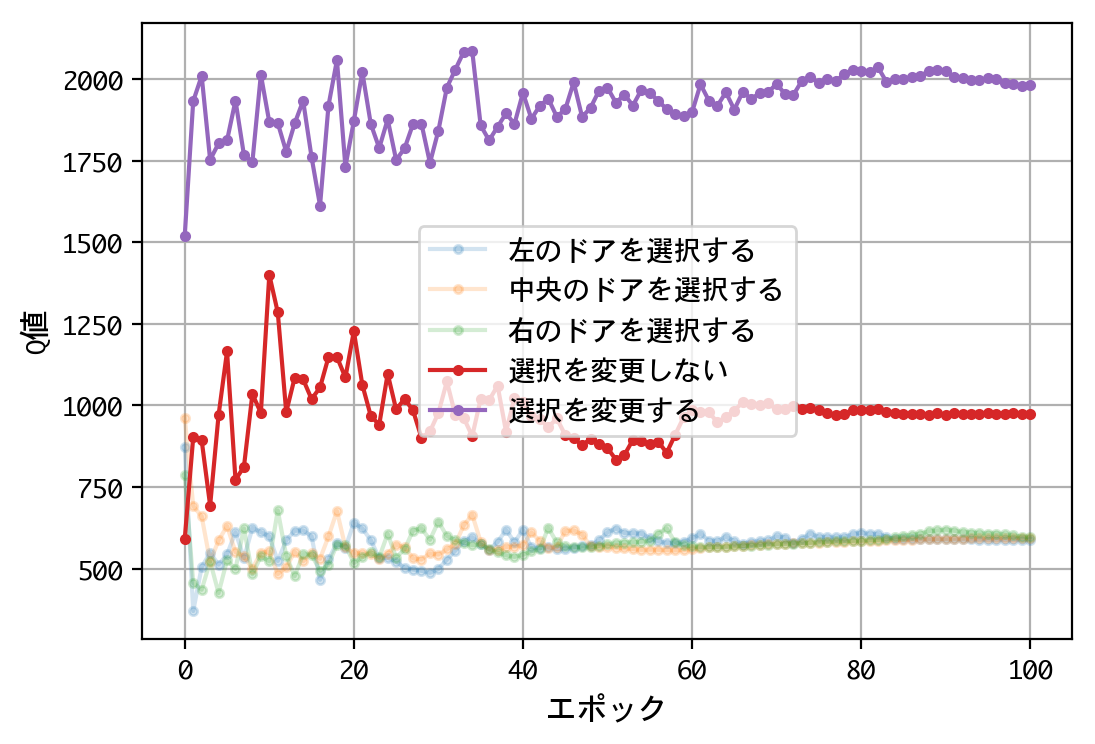

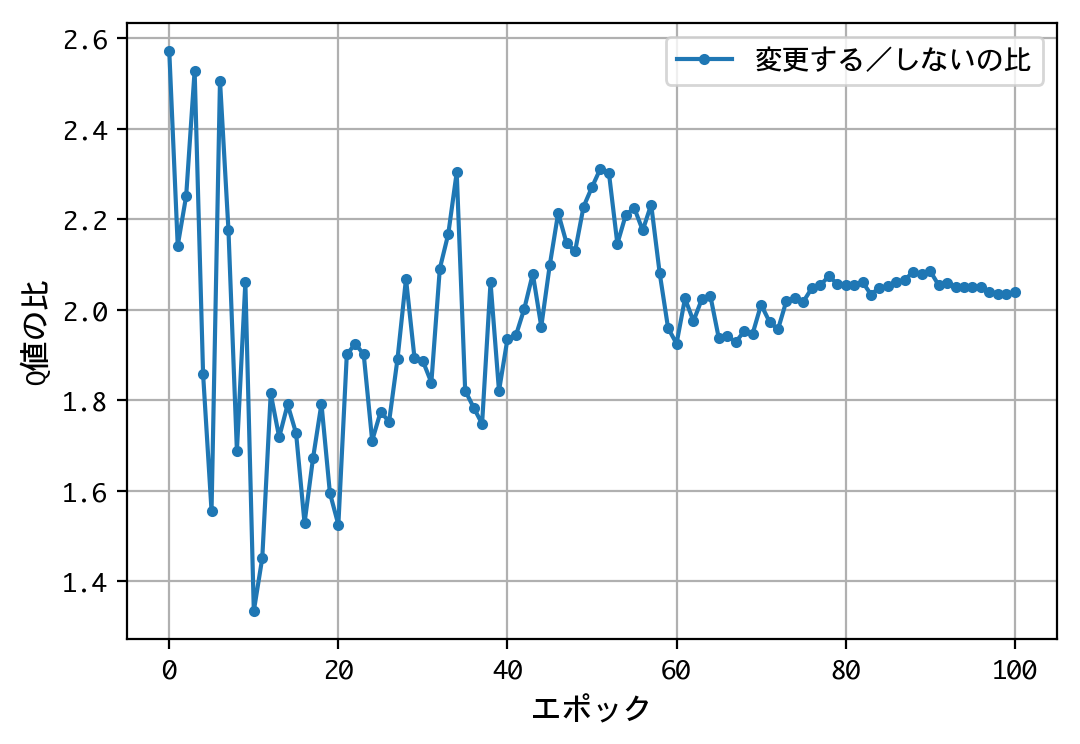

実戦勝率：0.647


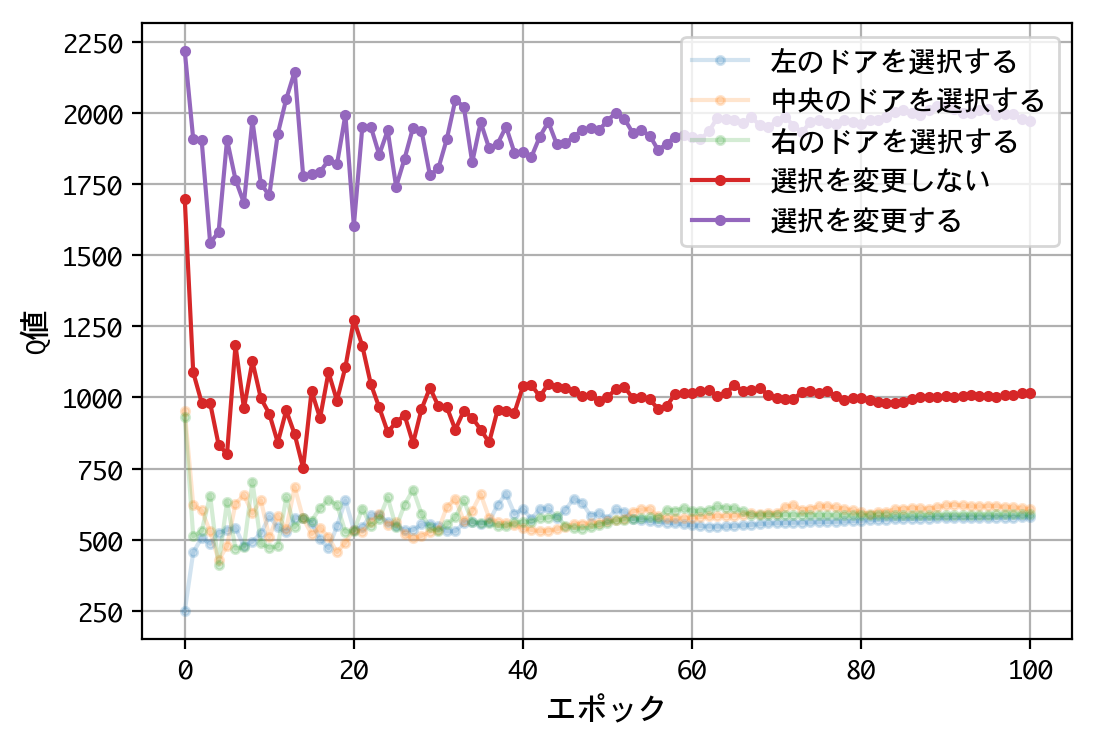

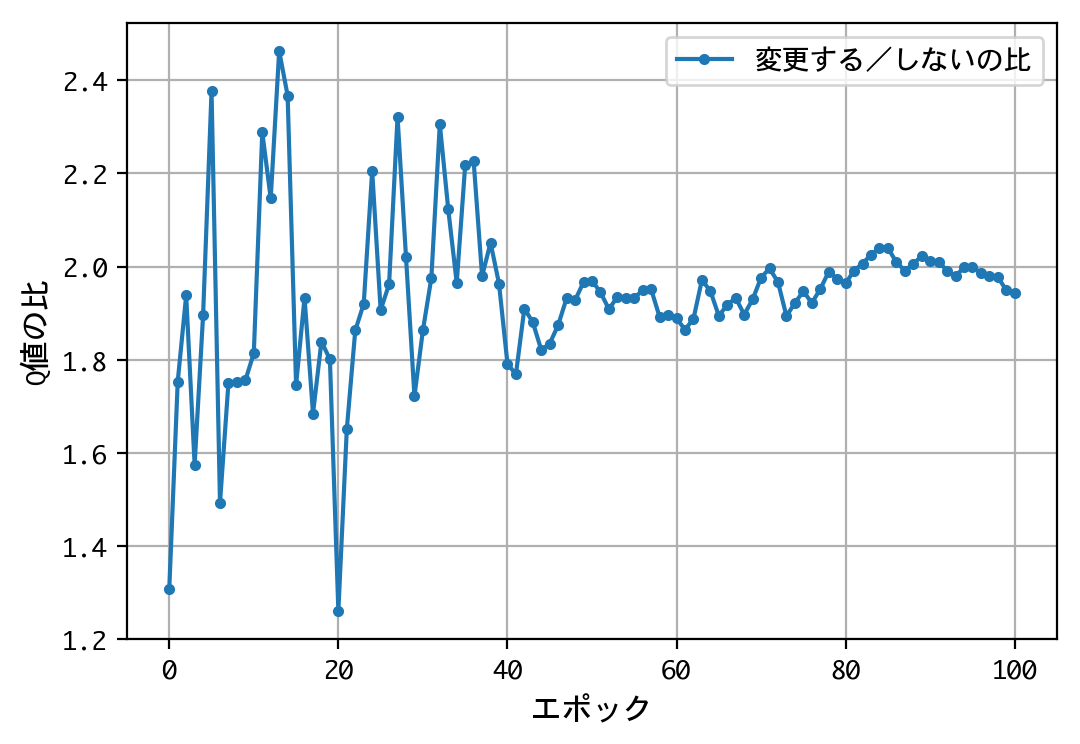

実戦勝率：0.667


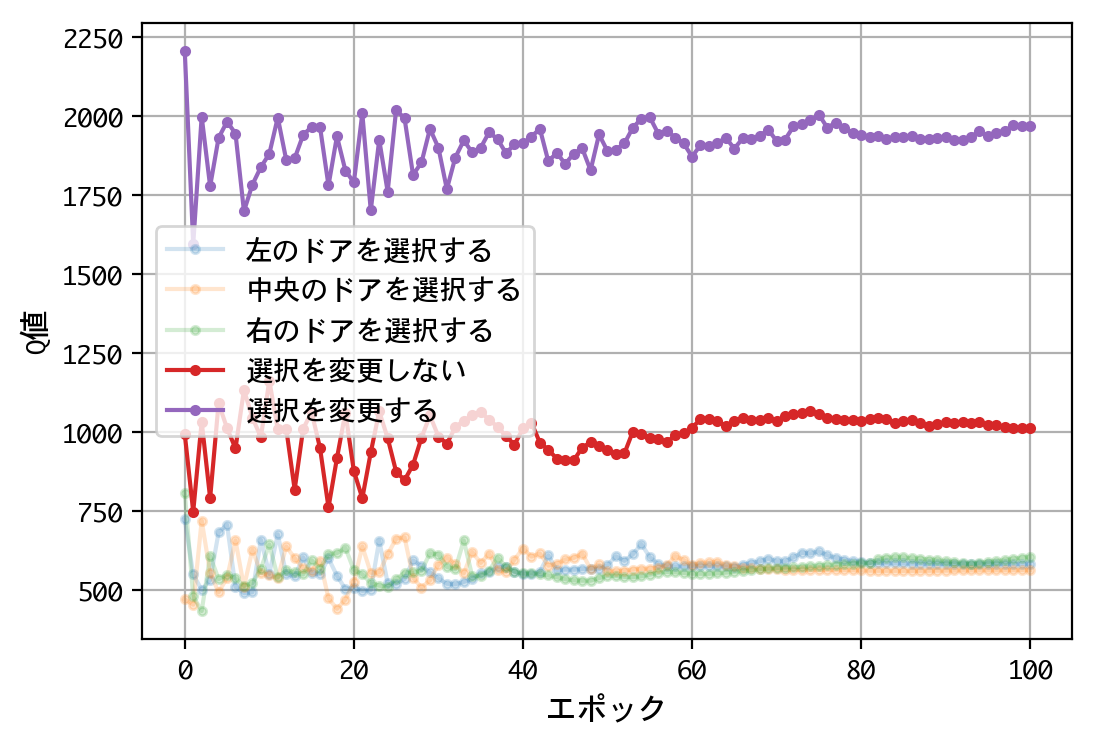

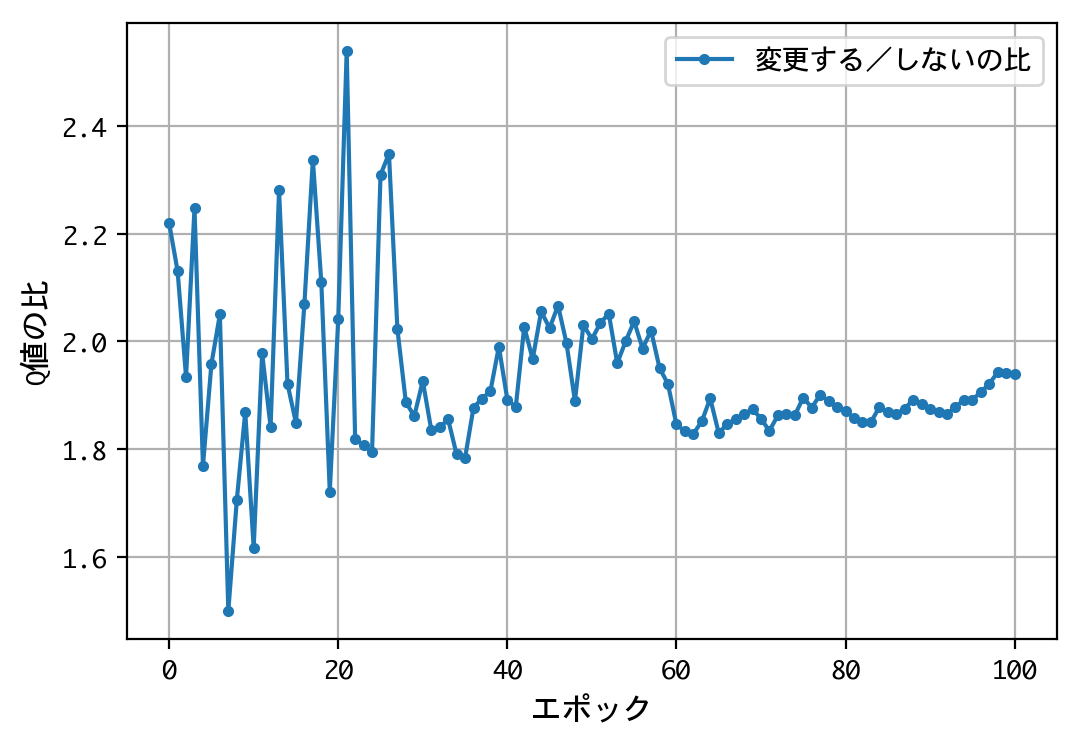

実戦勝率：0.653


In [2]:
for i in range(5):
    main()

説明は以下のとおりです。

- 最初のドアの選択について、Q値は同じような値に収束する。すなわち、どのドアを選択しても報酬の見込みは同じ。
- 二番目の選択（ドアの選択を変更する／しない）について、Q値の比は2.0程度に収束する。確率が五分五分なら1.0程度に収束するはずだが、そうはならない。ドアの選択を変更することにより、報酬の見込みが二倍になる。
- 得られたQ値をもとに実戦をおこなうことにより、67%前後の勝率を出すことができる。多くの人が考える五分五分以上の勝率を出しており、この訓練済みモデル（＝常にドアの選択を変更）の性能は良いものといえる。

## 考察

### 機械学習について

もし、プレーヤーの思考エンジンをアルゴリズムで（演繹的に）プログラミングしていたら、プログラマの（不正確な）論理を反映し、ドアの選択を変更しないものになっていたかもしれません。そして、五分五分の勝率が出ずに、悩んでいたかもしれません。

その点、Q値という指標を設定し、訓練により（帰納的に）自己学習させることにより、性能の良いエンジンを作成することができました。プログラマの論理を超えるという、機械学習という手法の特長が現れた一例といえるでしょう。

### モンティ・ホール問題について

ドアの選択を変更しようがしまいが同じ、という仮説は統計的に棄却されたことでしょう。

もっとも、その結果が、多くの人間の直感と食い違うというモヤモヤは依然として残ります。機械学習は、データに基づく事実を示しはするものの、納得のいく説明をしてくれるわけではないためです。

試みに、@[mastar_3104](https://qiita.com/mastar_3104)氏の記事[モンティ・ホール問題をプログラミングで解く](https://qiita.com/mastar_3104/items/a227f3665b95ffe73a36#%E3%81%AA%E3%81%9C12%E3%81%A7%E3%81%AF%E3%81%AA%E3%81%84%E3%81%AE%E3%81%8B)にならい、ドアの開放後に、こっそり正解をシャッフルさせてみましょう。

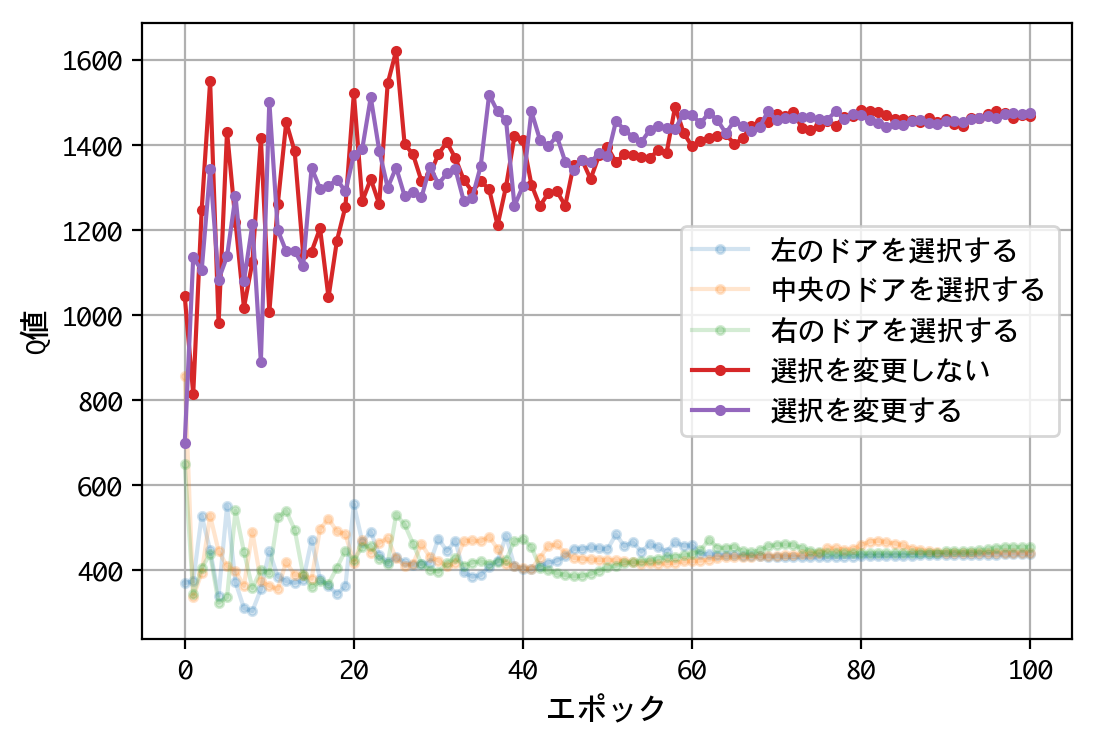

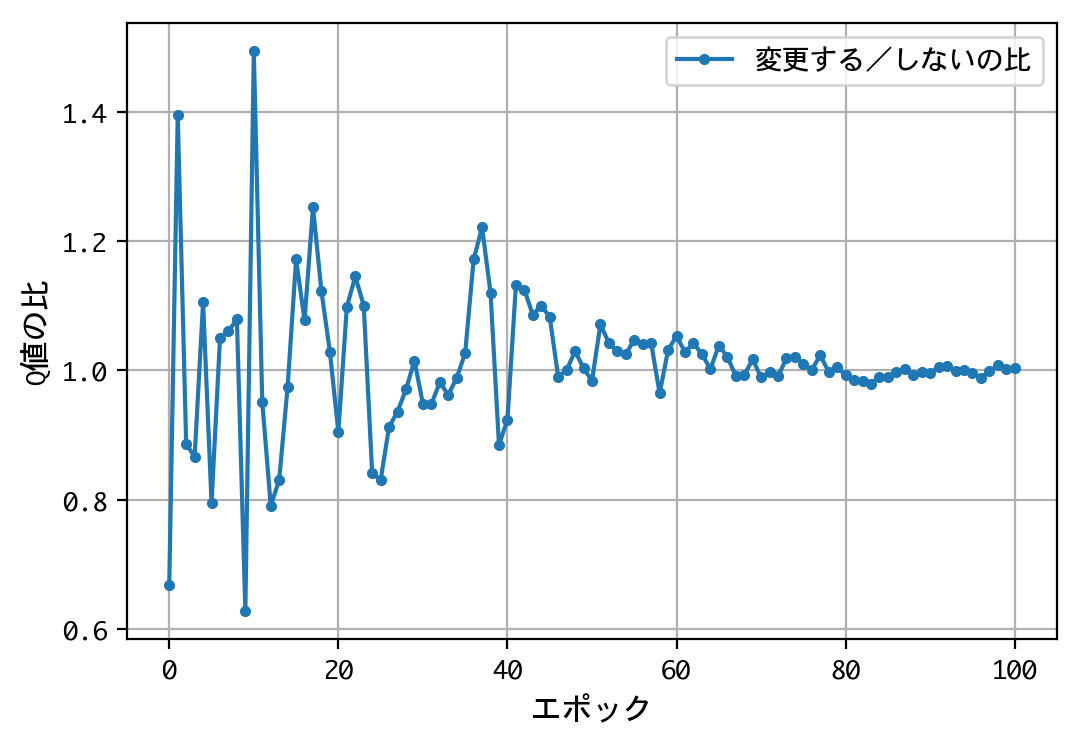

実戦勝率：0.491


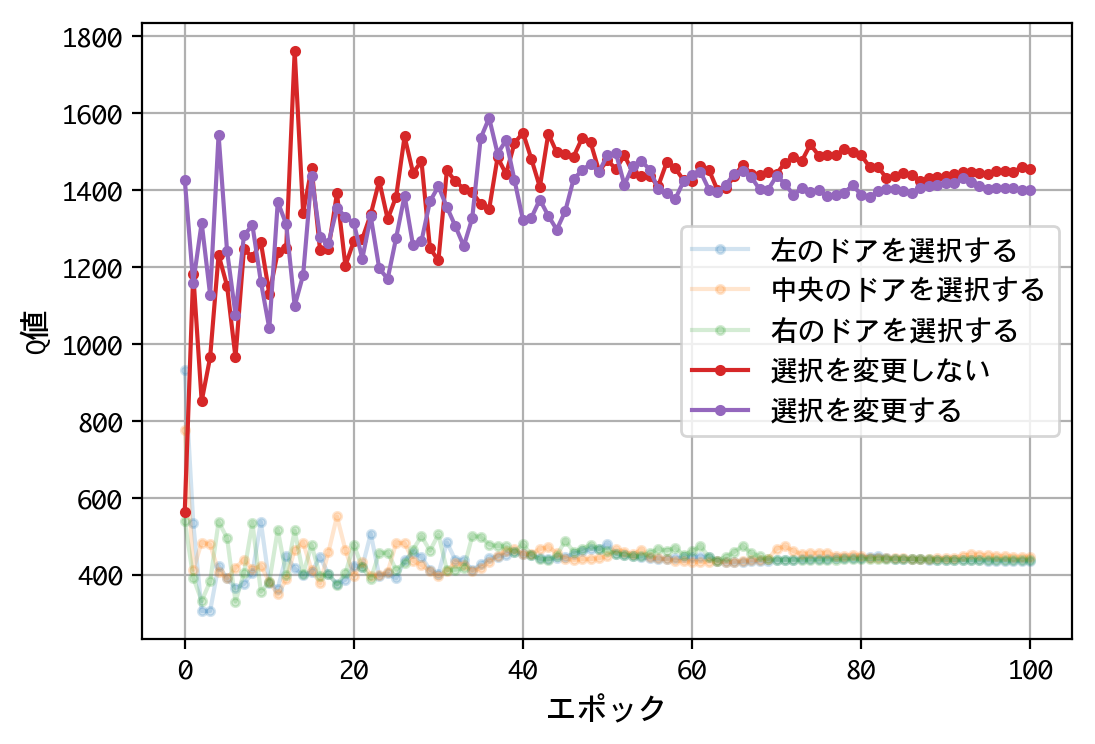

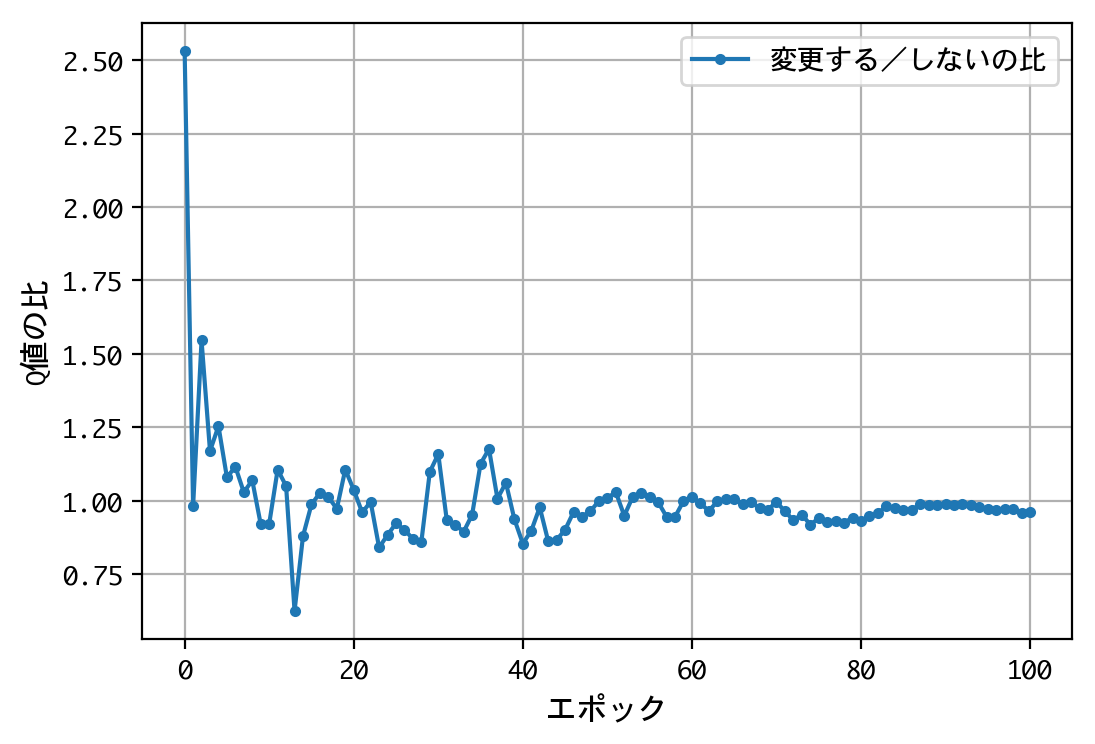

実戦勝率：0.514


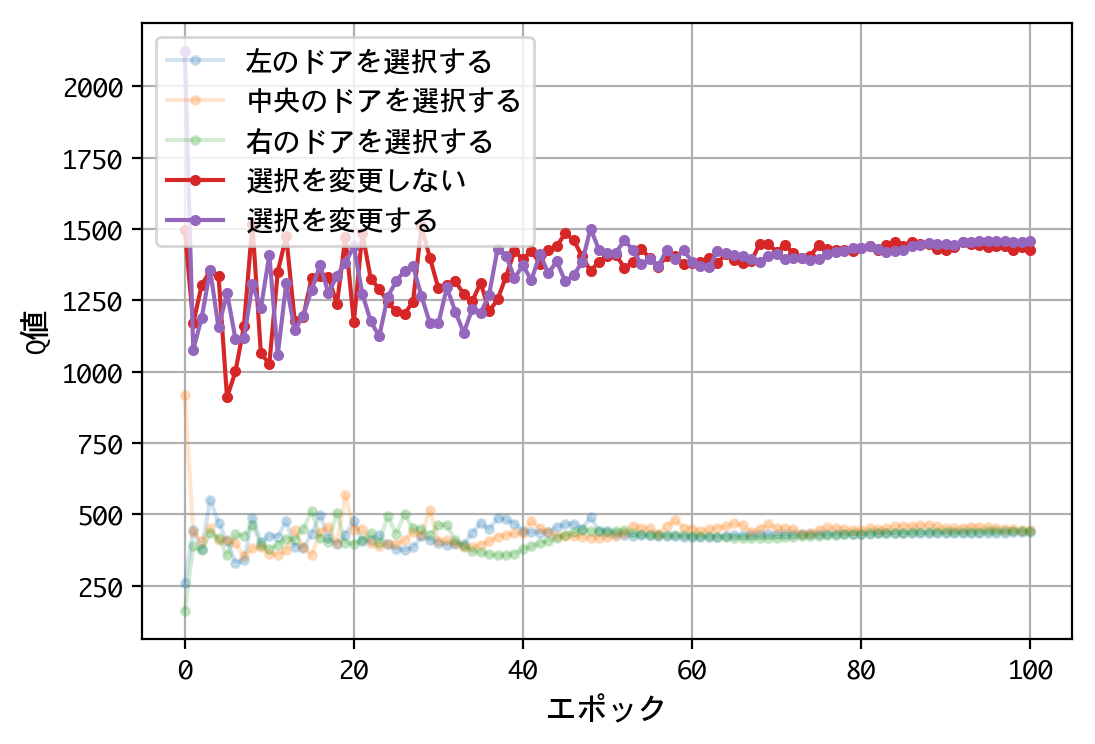

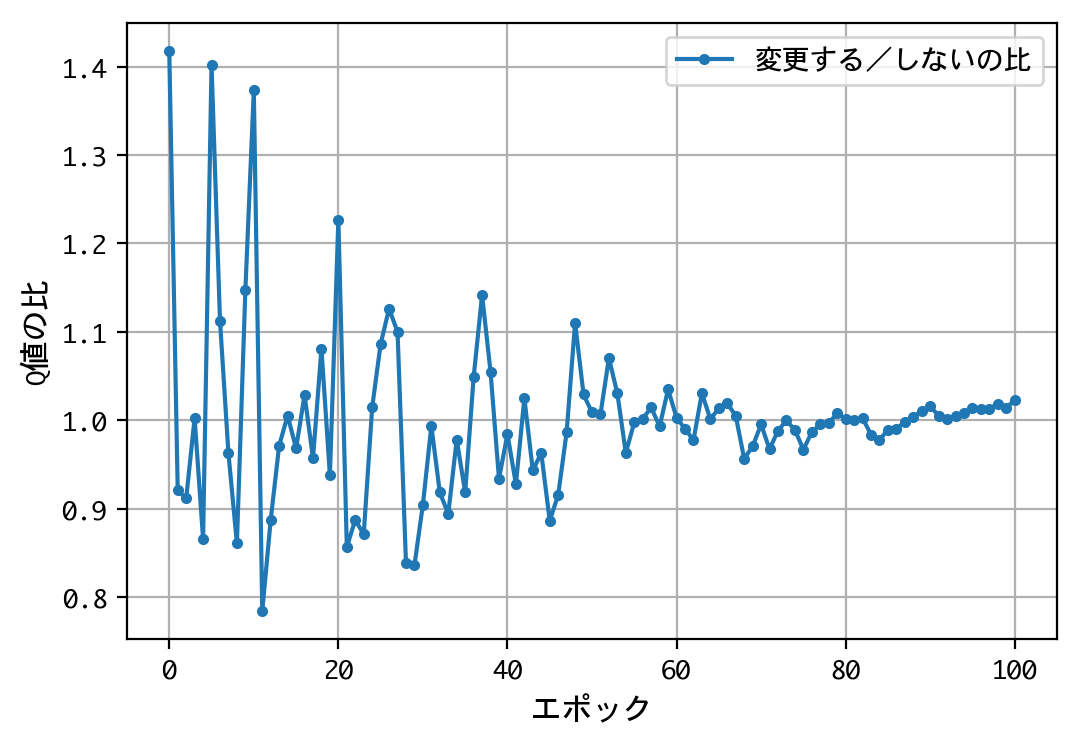

実戦勝率：0.516


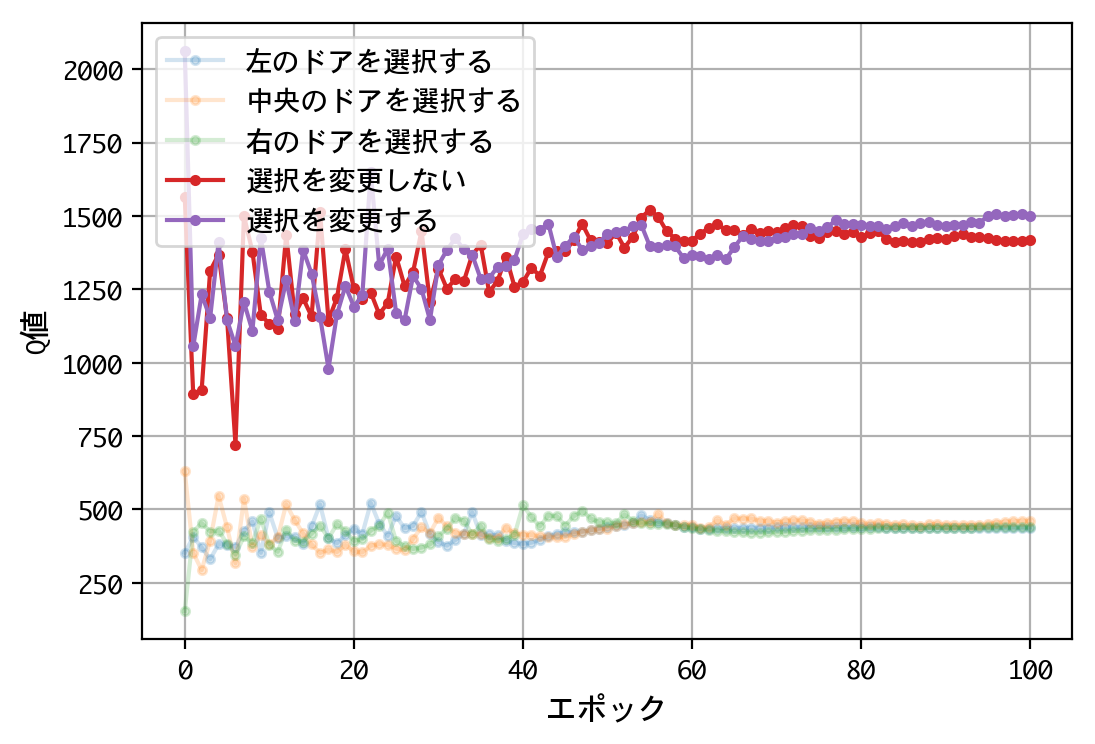

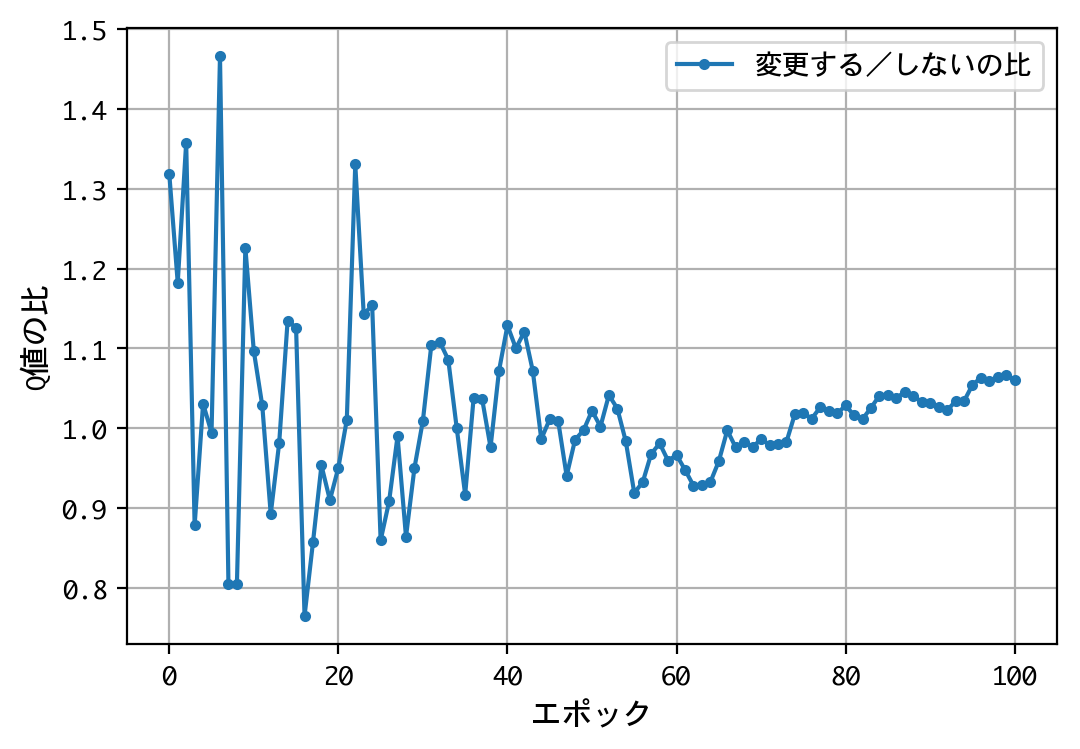

実戦勝率：0.528


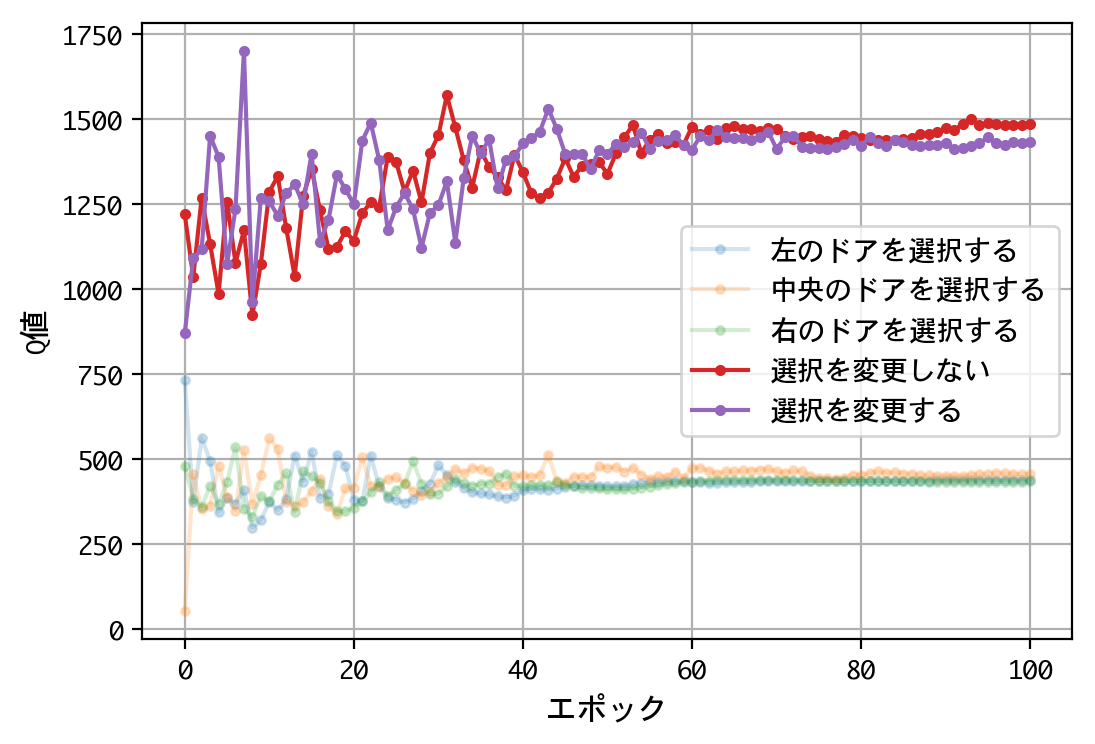

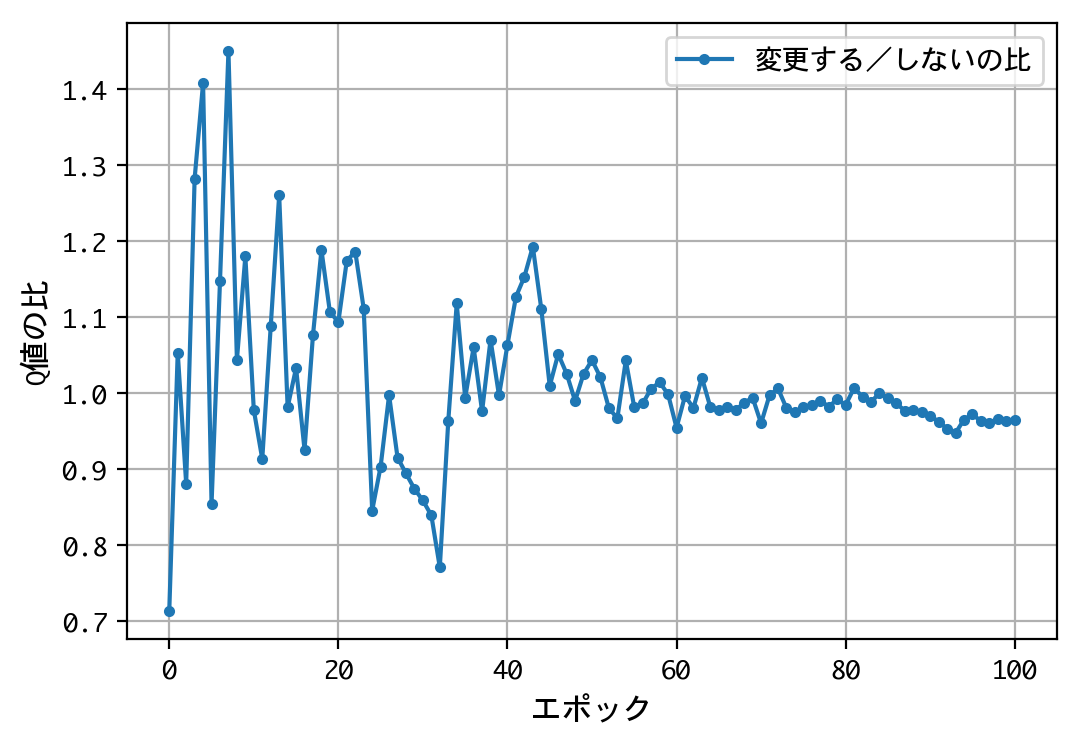

実戦勝率：0.513


In [3]:
class Monty:
    def reset(self):
        # ゲームを初期化
        m_doors = np.zeros(3)
        self.__car = np.zeros(3)
        self.__car[nrand.randint(3)] = 1.
        return m_doors
    
    def open(self, p_doors):
        m_doors = p_doors.copy()
        
        # ドアを一つ開ける
        t = self.__car + m_doors
        choices = np.where(t == 0.)[0]
        choice = nrand.randint(choices.size)
        m_doors[choices[choice]] = 2.
        
        # 正解をこっそりシャッフルする
        self.__shuffle(m_doors)
        
        return m_doors
    
    def judge(self, p_doors):
        # 正解判定
        t = np.where(p_doors == 1.)[0][0]
        u = np.where(self.__car == 1.)[0][0]
        judgement = 1000. if t == u else 0.
        return judgement

    def __shuffle(self, m_doors):
        choices = np.where(m_doors != 2.)[0]
        choice = nrand.randint(choices.size)
        self.__car = np.zeros(3)
        self.__car[choices[choice]] = 1.

for i in range(5):
    main()

結果が変わりましたね。1000人近い博士号保持者を含む、多くの人の直感に合う結果となりました。

これをどう説明したら良いのでしょう。私なりに説明を試みます。

### 不平等な二択

実は、モンティがドアを開けるのは、親切であると同時に、**フェイク**でもあります。

ドアを開けた上で、選択を変更しても良いということは、元々三択だったのが、**不平等な二択**に変わったことを意味しています。仮にプレーヤーが選択したのが左のドアだったとして、モンティは以下の二択を迫っています。

- 選択肢１：左のドアを選択する
- 選択肢２：中央・右のドアを選択する（一方は開放済み）

この二択が（モンティにとって）不平等なのは、理解して頂けると思います。選択肢１の正解確率は1/3、選択肢２の正解確率は2/3ですから。論理的に考えれば、誰でも後者に賭け直すことでしょう。

ところが、ドアを開けるというモンティの行為は、プレーヤーに対するフェイクとしても機能します。不平等な二択が、一見平等な二択に見えてしまうのです。そして、プレーヤーは選択を誤ってしまいます。

正解のシャッフルには、この不平等な二択を、再び平等な二択に戻す効果があったのです。

### 再び、機械学習について

機械学習は、こうした説明をしてくれることがありません。主としてディープラーニングに牽引され、機械学習が発展しても、人間の人間らしさ——ヒューマニティ——は保たれるのです。

新しい種類の学習アーキテクチャが現れれば、それもわかりませんが——命ある限り、機械と人類の行く末を見守ることにしましょう。